# Importing Libraries and loading datasets

In [1]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip


--2025-03-09 15:33:17--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2025-03-09 15:33:17--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-03-09 15:33:17--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip.2’

gl

In [2]:
# Install NLTK data if not already installed (optional)
import nltk
nltk.download('stopwords')

import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.text import Tokenizer, one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv1D, LSTM, GlobalMaxPooling1D, Embedding

from sklearn.model_selection import train_test_split

# In Google Colab, upload your files using the Files interface or mount your Google Drive.
# For example, if you mounted your drive, you could use a path like '/content/drive/MyDrive/IMDB Dataset.csv'
movie_reviews = pd.read_csv("IMDB Dataset.csv")  # Adjust path as necessary

# Quick checks on the dataset
print("Missing values exist?", movie_reviews.isnull().values.any())
print("Dataset shape:", movie_reviews.shape)
print("Dataset preview:")
print(movie_reviews.head())
print("Sample review:", movie_reviews["review"][3])


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Missing values exist? False
Dataset shape: (50000, 2)
Dataset preview:
                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive
Sample review: Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his parents are fighting all the time.<br /><br />This movie is slower than a soap opera... and suddenly, Jake decides to become Rambo and kill the zombie.<br /><br />OK, first of all when you're going to make a film you must Decide if its a thriller or a drama! As a drama the movie is watchable. Parents are divorcing & arguing like in real life. And then we have Jake with his closet which totally ruins all the film! I expected to see a BO

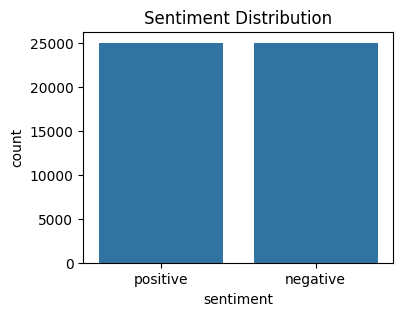

In [3]:
# Section 2: Visualizing Sentiment Distribution (Smaller Figure)
plt.figure(figsize=(4, 3))
sns.countplot(x='sentiment', data=movie_reviews)
plt.title('Sentiment Distribution')
plt.show()


In [4]:
# Section 3: Preprocessing Text Data

# Regular expression to remove HTML tags
TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    return TAG_RE.sub('', text)

def preprocess_text(sen):
    # Remove HTML tags
    sentence = remove_tags(sen)
    # Remove punctuation and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)
    # Remove single characters
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)
    # Remove extra spaces
    sentence = re.sub(r'\s+', ' ', sentence)
    return sentence

# Preprocess all the reviews in the dataset
X = [preprocess_text(sen) for sen in movie_reviews['review']]
print("Preprocessed sample review:", X[3])


Preprocessed sample review: Basically there a family where little boy Jake thinks there a zombie in his closet his parents are fighting all the time This movie is slower than soap opera and suddenly Jake decides to become Rambo and kill the zombie OK first of all when you re going to make film you must Decide if its thriller or drama As drama the movie is watchable Parents are divorcing arguing like in real life And then we have Jake with his closet which totally ruins all the film expected to see BOOGEYMAN similar movie and instead watched drama with some meaningless thriller spots out of just for the well playing parents descent dialogs As for the shots with Jake just ignore them 


In [5]:
# Section 4: Encode Labels and Split the Data

# Convert sentiment labels to binary values (1 for positive, 0 for negative)
y = movie_reviews['sentiment'].map(lambda x: 1 if x == "positive" else 0).values

# Split the data into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# Quick check on the splits
print("Training set size:", len(X_train))
print("Testing set size:", len(X_test))


Training set size: 40000
Testing set size: 10000


In [6]:
# Section 5: Tokenization and Padding

# Create a tokenizer with a maximum vocabulary size of 5000 words
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

# Convert texts to sequences of integers
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Define vocabulary size (+1 for the reserved 0 index)
vocab_size = len(tokenizer.word_index) + 1

# Pad sequences to a fixed length (e.g., 100 words per review)
maxlen = 100
X_train_pad = pad_sequences(X_train_seq, padding='post', maxlen=maxlen)
X_test_pad = pad_sequences(X_test_seq, padding='post', maxlen=maxlen)

print("Shape of padded training data:", X_train_pad.shape)
print("Shape of padded testing data:", X_test_pad.shape)


Shape of padded training data: (40000, 100)
Shape of padded testing data: (10000, 100)


In [7]:
# Section 6: Prepare GloVe Embedding Matrix

from numpy import asarray, zeros

# Load GloVe embeddings (ensure 'glove.6B.100d.txt' is uploaded or accessible in your Colab environment)
embeddings_dictionary = {}
with open('glove.6B.100d.txt', encoding="utf8") as glove_file:
    for line in glove_file:
        records = line.split()
        word = records[0]
        vector_dimensions = asarray(records[1:], dtype='float32')
        embeddings_dictionary[word] = vector_dimensions

# Create the embedding matrix for our vocabulary
embedding_dim = 100
embedding_matrix = zeros((vocab_size, embedding_dim))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

print("Embedding matrix shape:", embedding_matrix.shape)


Embedding matrix shape: (92547, 100)


# Simple Models

In [8]:
# Section 7: Build and Train a Simple Neural Network Model

# Build the model
model_nn_simple = Sequential()
embedding_layer = Embedding(vocab_size, embedding_dim, weights=[embedding_matrix],
                            input_length=maxlen, trainable=False)
model_nn_simple.add(embedding_layer)
model_nn_simple.add(Flatten())
model_nn_simple.add(Dense(1, activation='sigmoid'))

# Compile the model
model_nn_simple.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(model_nn_simple.summary())

# Train the model
history_nn_simple = model_nn_simple.fit(X_train_pad, y_train, batch_size=128, epochs=10, verbose=1, validation_split=0.2)

# Evaluate the model on the test set
score_nn = model_nn_simple.evaluate(X_test_pad, y_test, verbose=1)
print("Simple NN - Test Score:", score_nn[0])
print("Simple NN - Test Accuracy:", score_nn[1])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │       9,254,700 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,254,700 (35.30 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 9,254,700 (35.30 MB)

None
Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - acc: 0.6270 - loss: 0.6441 - val_acc: 0.7345 - val_loss: 0.5335
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - acc: 0.7677 - loss: 0.4907 - val_acc: 0.7431 - val_loss: 0.5205
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - acc: 0.7889 - loss: 0.4503 - val_acc: 0.7279 - val_loss: 0.5510
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - acc: 0.8066 - loss: 0.4292 - val_acc: 0.7400 - val_loss: 0.5291
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - acc: 0.8191 - loss: 0.4060 - val_acc: 0.7433 - val_loss: 0.5270
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - acc: 0.8267 - loss: 0.3948 - val_acc: 0.7404 - val_loss: 0.5406
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - acc: 0.8324 - loss: 0.3787 - val_acc: 0.7289 - val_loss: 0.5704
Epoch 8/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - acc: 0.8293 - loss: 0.3810 - val_acc: 0.7369 - val_loss: 0.5522
Epoch 9/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

In [9]:
print(model_nn_simple.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (128, 100, 100)             │       9,254,700 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (128, 10000)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (128, 1)                    │          10,001 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,284,705 (35.42 MB)

 Trainable params: 10,001 (39.07 KB)

 Non-trainable params: 9,254,700 (35.30 MB)

 Optimizer params: 20,004 (78.14 KB)

None


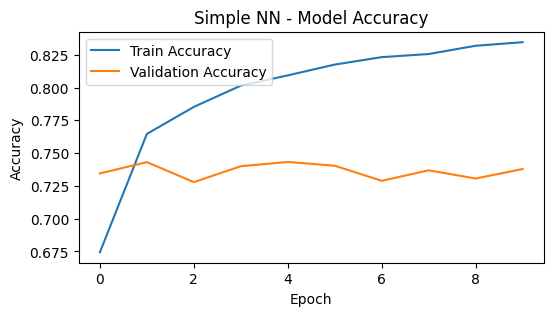

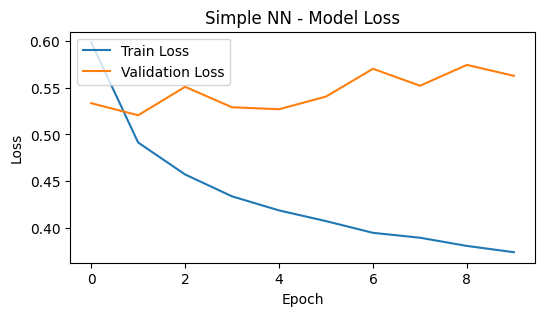

In [10]:
# Section 7a: Visualizing Simple NN Performance

# Plot training and validation accuracy
plt.figure(figsize=(6, 3))
plt.plot(history_nn_simple.history['acc'], label='Train Accuracy')
plt.plot(history_nn_simple.history['val_acc'], label='Validation Accuracy')
plt.title('Simple NN - Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

# Plot training and validation loss
plt.figure(figsize=(6, 3))
plt.plot(history_nn_simple.history['loss'], label='Train Loss')
plt.plot(history_nn_simple.history['val_loss'], label='Validation Loss')
plt.title('Simple NN - Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()


In [11]:
# Section 8: Build and Train a Convolutional Neural Network (CNN) Model

# Build the CNN model
model_cnn_simple = Sequential()
embedding_layer = Embedding(vocab_size, embedding_dim, weights=[embedding_matrix],
                            input_length=maxlen, trainable=False)
model_cnn_simple.add(embedding_layer)
model_cnn_simple.add(Conv1D(128, 5, activation='relu'))
model_cnn_simple.add(GlobalMaxPooling1D())
model_cnn_simple.add(Dense(1, activation='sigmoid'))

# Compile the CNN model
model_cnn_simple.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(model_cnn_simple.summary())

# Train the CNN model
history_cnn_simple = model_cnn_simple.fit(X_train_pad, y_train, batch_size=128, epochs=10, verbose=1, validation_split=0.2)

# Evaluate the CNN model on the test set
score_cnn = model_cnn_simple.evaluate(X_test_pad, y_test, verbose=1)
print("CNN - Test Score:", score_cnn[0])
print("CNN - Test Accuracy:", score_cnn[1])


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ ?                           │       9,254,700 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d                 │ ?                           │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,254,700 (35.30 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 9,254,700 (35.30 MB)

None
Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 28s 105ms/step - acc: 0.6795 - loss: 0.5836 - val_acc: 0.8115 - val_loss: 0.4099
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 41s 106ms/step - acc: 0.8358 - loss: 0.3703 - val_acc: 0.8298 - val_loss: 0.3754
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 42s 110ms/step - acc: 0.8637 - loss: 0.3172 - val_acc: 0.8456 - val_loss: 0.3495
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 38s 98ms/step - acc: 0.8879 - loss: 0.2778 - val_acc: 0.8478 - val_loss: 0.3433
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 41s 97ms/step - acc: 0.9044 - loss: 0.2433 - val_acc: 0.8418 - val_loss: 0.3557
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 41s 98ms/step - acc: 0.9191 - loss: 0.2182 - val_acc: 0.8372 - val_loss: 0.3670
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 47s 124ms/step - acc: 0.9381 - loss: 0.1871 - val_acc: 0.8491 - val_loss: 0.3474
Epoch 8/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 39s 117ms/step - acc: 0.9531 - loss: 0.1617 - val_acc: 0.8475 - val_loss: 0.3537
Epoch 9/10
250/250 ━━━━━━━━━━━

In [12]:
print(model_cnn_simple.summary())

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (128, 100, 100)             │       9,254,700 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (128, 96, 128)              │          64,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d                 │ (128, 128)                  │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (128, 1)                    │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,447,473 (36.04 MB)

 Trainable params: 64,257 (251.00 KB)

 Non-trainable params: 9,254,700 (35.30 MB)

 Optimizer params: 128,516 (502.02 KB)

None


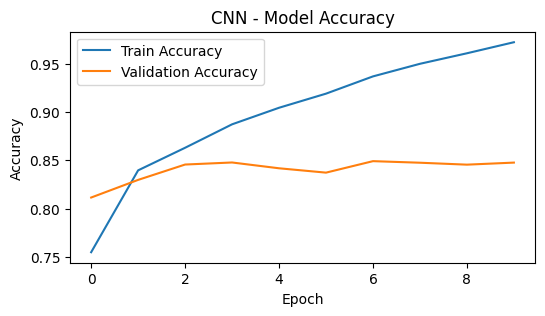

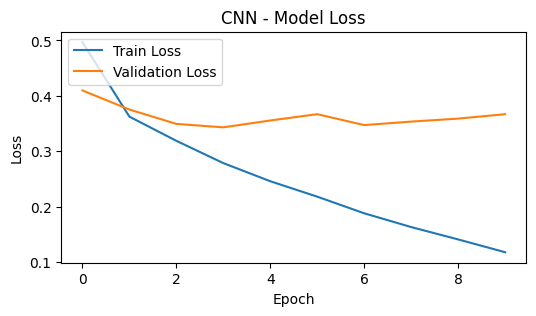

In [13]:
# Section 8a: Visualizing CNN Performance

# Plot training and validation accuracy for CNN
plt.figure(figsize=(6, 3))
plt.plot(history_cnn_simple.history['acc'], label='Train Accuracy')
plt.plot(history_cnn_simple.history['val_acc'], label='Validation Accuracy')
plt.title('CNN - Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

# Plot training and validation loss for CNN
plt.figure(figsize=(6, 3))
plt.plot(history_cnn_simple.history['loss'], label='Train Loss')
plt.plot(history_cnn_simple.history['val_loss'], label='Validation Loss')
plt.title('CNN - Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()


In [14]:
# Section 9: Build and Train a Recurrent Neural Network (RNN) Model with LSTM

# Build the RNN model using an LSTM layer
model_rnn_simple = Sequential()
embedding_layer = Embedding(vocab_size, embedding_dim, weights=[embedding_matrix],
                            input_length=maxlen, trainable=False)
model_rnn_simple.add(embedding_layer)
model_rnn_simple.add(LSTM(128))
model_rnn_simple.add(Dense(1, activation='sigmoid'))

# Compile the RNN model
model_rnn_simple.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(model_rnn_simple.summary())

# Train the RNN model
history_rnn_simple = model_rnn_simple.fit(X_train_pad, y_train, batch_size=128, epochs=10, verbose=1, validation_split=0.2)

# Evaluate the RNN model on the test set
score_rnn = model_rnn_simple.evaluate(X_test_pad, y_test, verbose=1)
print("RNN - Test Score:", score_rnn[0])
print("RNN - Test Accuracy:", score_rnn[1])


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ ?                           │       9,254,700 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,254,700 (35.30 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 9,254,700 (35.30 MB)

None
Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 91s 354ms/step - acc: 0.6367 - loss: 0.6240 - val_acc: 0.7876 - val_loss: 0.4690
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 86s 344ms/step - acc: 0.7917 - loss: 0.4537 - val_acc: 0.8161 - val_loss: 0.4034
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 143s 350ms/step - acc: 0.8174 - loss: 0.3984 - val_acc: 0.8319 - val_loss: 0.3789
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 87s 347ms/step - acc: 0.8297 - loss: 0.3807 - val_acc: 0.8372 - val_loss: 0.3688
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 148s 369ms/step - acc: 0.8449 - loss: 0.3517 - val_acc: 0.8464 - val_loss: 0.3506
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 136s 345ms/step - acc: 0.8556 - loss: 0.3310 - val_acc: 0.8516 - val_loss: 0.3390
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 142s 345ms/step - acc: 0.8633 - loss: 0.3171 - val_acc: 0.8536 - val_loss: 0.3494
Epoch 8/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 143s 348ms/step - acc: 0.8694 - loss: 0.3060 - val_acc: 0.8556 - val_loss: 0.3409
Epoch 9/10
250/250 ━━━

In [15]:
print(model_rnn_simple.summary())

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ (128, 100, 100)             │       9,254,700 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (128, 128)                  │         117,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (128, 1)                    │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,606,833 (36.65 MB)

 Trainable params: 117,377 (458.50 KB)

 Non-trainable params: 9,254,700 (35.30 MB)

 Optimizer params: 234,756 (917.02 KB)

None


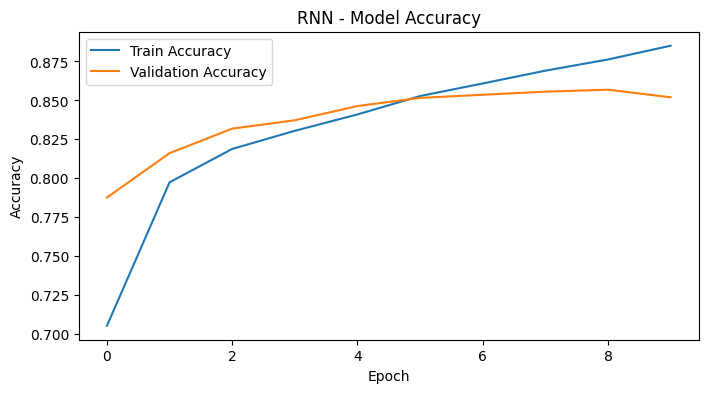

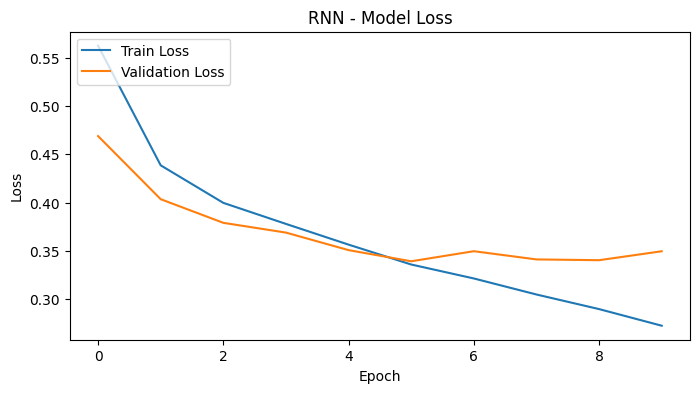

In [16]:
# Section 9a: Visualizing RNN Performance

# Plot training and validation accuracy for the RNN model
plt.figure(figsize=(8, 4))
plt.plot(history_rnn_simple.history['acc'], label='Train Accuracy')
plt.plot(history_rnn_simple.history['val_acc'], label='Validation Accuracy')
plt.title('RNN - Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.show()

# Plot training and validation loss for the RNN model
plt.figure(figsize=(8, 4))
plt.plot(history_rnn_simple.history['loss'], label='Train Loss')
plt.plot(history_rnn_simple.history['val_loss'], label='Validation Loss')
plt.title('RNN - Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')
plt.show()


In [19]:
# Section 10: Predicting on a Sample Review

# Select a sample review from the preprocessed list (e.g., the 58th review)
sample_review = X[57]
print("Original Review:", sample_review)

# Convert the sample review to a sequence of integers using the tokenizer
sample_seq = tokenizer.texts_to_sequences([sample_review])

# Pad the sequence to ensure it has the same length as the training data
sample_pad = pad_sequences(sample_seq, padding='post', maxlen=maxlen)

# Predict sentiment using one of your trained models (e.g., the RNN model)
prediction = model_rnn_simple.predict(sample_pad)
print("Predicted Sentiment (RNN):", prediction)


Original Review: I laughed all the way through this rotten movie It so unbelievable woman leaves her husband after many years of marriage has breakdown in front of real estate office What happens The office manager comes outside and offers her job Hilarious Next thing you know the two women are going at it Yep they re lesbians Nothing rings true in this Lifetime for Women with nothing better to do movie Clunky dialogue like don want to spend the rest of my life feeling like had chance to be happy and didn take it doesn help There a wealthy distant mother who disapproves of her daughter new relationship sassy black maid unbelievable that in the year film gets made in which there a sassy black maid Hattie McDaniel must be turning in her grave The woman has husband who freaks out and wants custody of the snotty teenage kids Sheesh No cliche is left unturned 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
Predicted Sentiment (RNN): [[0.3430346]]


In [20]:
# Get the true sentiment from the original dataset (for the 58th review)
true_sentiment = movie_reviews['sentiment'][57]
print("True Sentiment:", true_sentiment)

# Convert the model's probability output to a binary label (threshold at 0.5)
predicted_label = "positive" if prediction[0] > 0.5 else "negative"
print("Predicted Sentiment:", predicted_label)



True Sentiment: negative
Predicted Sentiment: negative


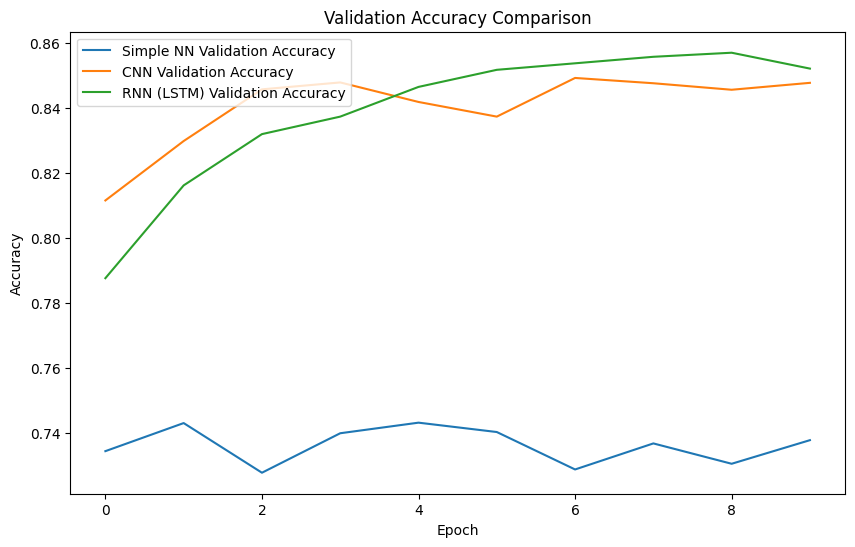

Simple NN Test Accuracy: 0.7389000058174133
CNN Test Accuracy: 0.8435999751091003
RNN (LSTM) Test Accuracy: 0.847599983215332


In [21]:
# Section 11: Compare and Visualize Model Performance

# Compare validation accuracy across the three models
plt.figure(figsize=(10, 6))
plt.plot(history_nn_simple.history['val_acc'], label='Simple NN Validation Accuracy')
plt.plot(history_cnn_simple.history['val_acc'], label='CNN Validation Accuracy')
plt.plot(history_rnn_simple.history['val_acc'], label='RNN (LSTM) Validation Accuracy')
plt.title('Validation Accuracy Comparison')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.show()

# Print test accuracy for each model
print("Simple NN Test Accuracy:", score_nn[1])
print("CNN Test Accuracy:", score_cnn[1])
print("RNN (LSTM) Test Accuracy:", score_rnn[1])


In [22]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix

# Get predicted binary labels for the entire test set for each model
pred_nn = (model_nn_simple.predict(X_test_pad) > 0.5).astype(int).flatten()
pred_cnn = (model_cnn_simple.predict(X_test_pad) > 0.5).astype(int).flatten()
pred_rnn = (model_rnn_simple.predict(X_test_pad) > 0.5).astype(int).flatten()

# Define a helper function to compute correct and incorrect predictions
def compute_results(y_true, y_pred):
    # Confusion matrix: [[TN, FP], [FN, TP]]
    cm = confusion_matrix(y_true, y_pred)
    correct = np.trace(cm)  # sum of diagonal elements (TP + TN)
    total = np.sum(cm)
    wrong = total - correct
    accuracy = correct / total
    return correct, wrong, accuracy

nn_correct, nn_wrong, nn_acc = compute_results(y_test, pred_nn)
cnn_correct, cnn_wrong, cnn_acc = compute_results(y_test, pred_cnn)
rnn_correct, rnn_wrong, rnn_acc = compute_results(y_test, pred_rnn)

# Create a DataFrame to display the results
results_table = pd.DataFrame({
    'Model': ['Simple NN', 'CNN', 'RNN (LSTM)'],
    'Correct Predictions': [nn_correct, cnn_correct, rnn_correct],
    'Incorrect Predictions': [nn_wrong, cnn_wrong, rnn_wrong],
    'Accuracy': [nn_acc, cnn_acc, rnn_acc]
})

print(results_table)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 21s 67ms/step
        Model  Correct Predictions  Incorrect Predictions  Accuracy
0   Simple NN                 7389                   2611    0.7389
1         CNN                 8436                   1564    0.8436
2  RNN (LSTM)                 8476                   1524    0.8476


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 19s 61ms/step


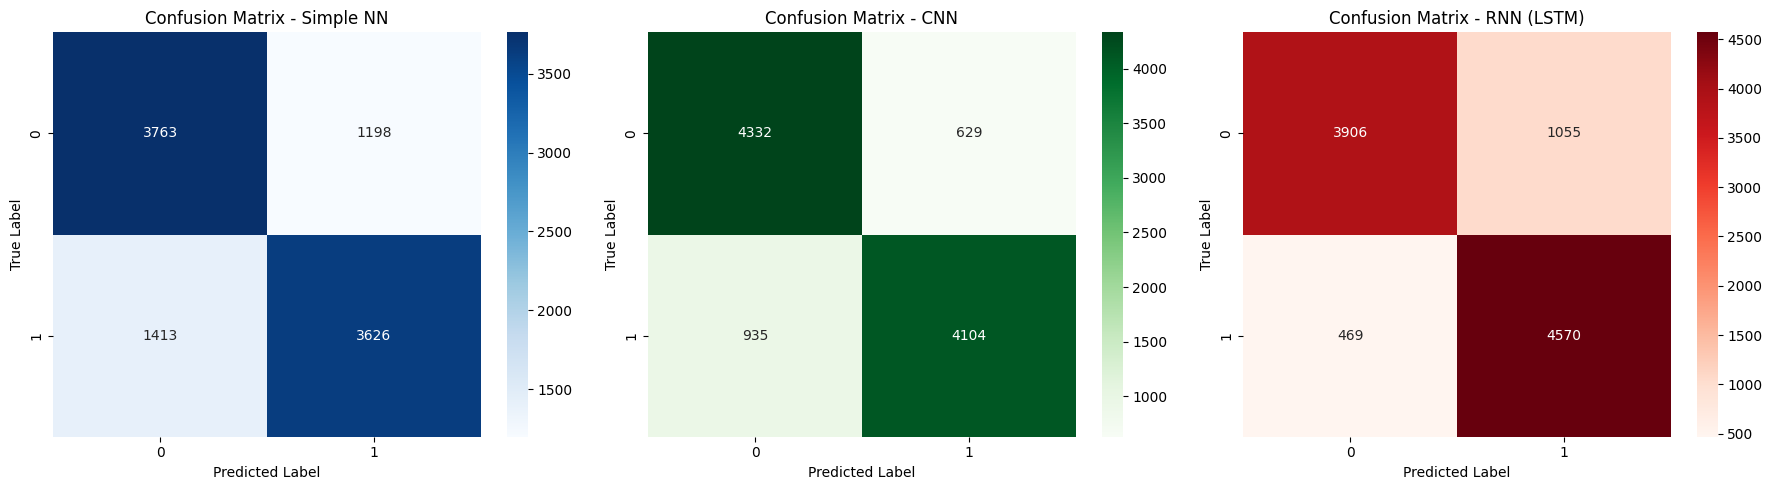

In [23]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Get predicted binary labels for the entire test set for each model
pred_nn = (model_nn_simple.predict(X_test_pad) > 0.5).astype(int).flatten()
pred_cnn = (model_cnn_simple.predict(X_test_pad) > 0.5).astype(int).flatten()
pred_rnn = (model_rnn_simple.predict(X_test_pad) > 0.5).astype(int).flatten()

# Compute confusion matrices for each model
cm_nn = confusion_matrix(y_test, pred_nn)
cm_cnn = confusion_matrix(y_test, pred_cnn)
cm_rnn = confusion_matrix(y_test, pred_rnn)

# Plot the confusion matrices side by side
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.heatmap(cm_nn, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Confusion Matrix - Simple NN')
axes[0].set_xlabel('Predicted Label')
axes[0].set_ylabel('True Label')

sns.heatmap(cm_cnn, annot=True, fmt='d', cmap='Greens', ax=axes[1])
axes[1].set_title('Confusion Matrix - CNN')
axes[1].set_xlabel('Predicted Label')
axes[1].set_ylabel('True Label')

sns.heatmap(cm_rnn, annot=True, fmt='d', cmap='Reds', ax=axes[2])
axes[2].set_title('Confusion Matrix - RNN (LSTM)')
axes[2].set_xlabel('Predicted Label')
axes[2].set_ylabel('True Label')

plt.tight_layout()
plt.show()


# Dropout and Early Stopping

In [24]:
#Simple NN with Dropout and Early Stopping
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Flatten, Conv1D, LSTM, GlobalMaxPooling1D, Embedding, Dropout

# Define EarlyStopping callback: stops training if validation loss doesn't improve for 3 epochs
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

model_nn_dropout = Sequential()
model_nn_dropout.add(Embedding(vocab_size, embedding_dim, weights=[embedding_matrix],
                       input_length=maxlen, trainable=False))
model_nn_dropout.add(Flatten())
model_nn_dropout.add(Dropout(0.3))  # Added dropout after flattening
model_nn_dropout.add(Dense(1, activation='sigmoid'))

model_nn_dropout.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
history_nn_dropout = model_nn_dropout.fit(X_train_pad, y_train, batch_size=128, epochs=20, verbose=1,
                          validation_split=0.2, callbacks=[early_stop])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - acc: 0.5951 - loss: 0.7063 - val_acc: 0.7174 - val_loss: 0.5489
Epoch 2/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - acc: 0.7242 - loss: 0.5420 - val_acc: 0.7391 - val_loss: 0.5252
Epoch 3/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - acc: 0.7521 - loss: 0.5074 - val_acc: 0.7400 - val_loss: 0.5202
Epoch 4/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - acc: 0.7618 - loss: 0.4933 - val_acc: 0.7436 - val_loss: 0.5187
Epoch 5/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - acc: 0.7655 - loss: 0.4851 - val_acc: 0.7370 - val_loss: 0.5331
Epoch 6/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - acc: 0.7698 - loss: 0.4821 - val_acc: 0.7212 - val_loss: 0.5538
Epoch 7/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - acc: 0.7675 - loss: 0.4841 - val_acc: 0.7334 - val_loss: 0.5382


In [25]:
print(model_nn_dropout.summary())

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)              │ (128, 100, 100)             │       9,254,700 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (128, 10000)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (128, 10000)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (128, 1)                    │          10,001 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,284,705 (35.42 MB)

 Trainable params: 10,001 (39.07 KB)

 Non-trainable params: 9,254,700 (35.30 MB)

 Optimizer params: 20,004 (78.14 KB)

None


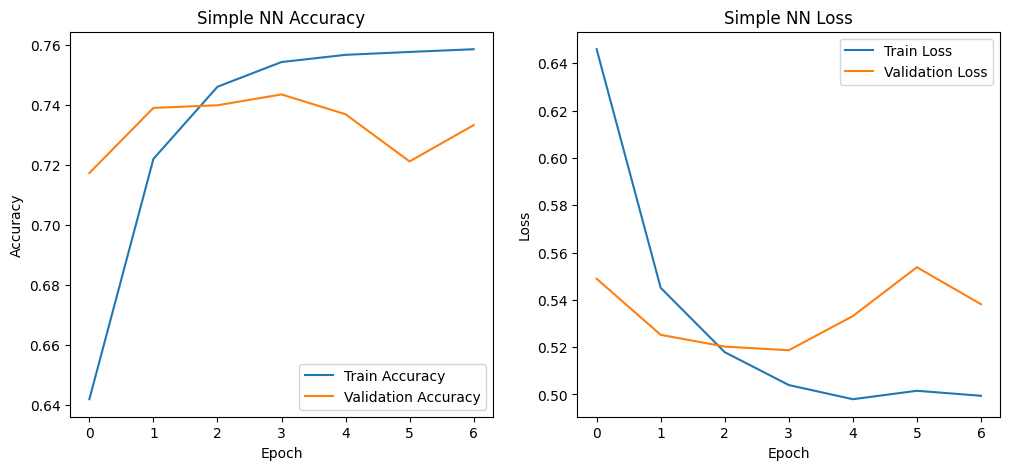

In [26]:
import matplotlib.pyplot as plt

# Visualize performance for the Simple NN
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_nn_dropout.history['acc'], label='Train Accuracy')
plt.plot(history_nn_dropout.history['val_acc'], label='Validation Accuracy')
plt.title('Simple NN Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_nn_dropout.history['loss'], label='Train Loss')
plt.plot(history_nn_dropout.history['val_loss'], label='Validation Loss')
plt.title('Simple NN Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [27]:
#CNN
model_cnn_dropout = Sequential()
model_cnn_dropout.add(Embedding(vocab_size, embedding_dim, weights=[embedding_matrix],
                        input_length=maxlen, trainable=False))
model_cnn_dropout.add(Conv1D(128, 5, activation='relu'))
model_cnn_dropout.add(Dropout(0.3))  # Added dropout after the convolution
model_cnn_dropout.add(GlobalMaxPooling1D())
model_cnn_dropout.add(Dense(1, activation='sigmoid'))

model_cnn_dropout.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
history_cnn_dropout = model_cnn_dropout.fit(X_train_pad, y_train, batch_size=128, epochs=20, verbose=1,
                           validation_split=0.2, callbacks=[early_stop])


Epoch 1/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 32s 121ms/step - acc: 0.6628 - loss: 0.6069 - val_acc: 0.8214 - val_loss: 0.4228
Epoch 2/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 30s 120ms/step - acc: 0.8241 - loss: 0.3903 - val_acc: 0.8369 - val_loss: 0.3819
Epoch 3/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 41s 120ms/step - acc: 0.8445 - loss: 0.3508 - val_acc: 0.8414 - val_loss: 0.3652
Epoch 4/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 41s 121ms/step - acc: 0.8719 - loss: 0.3074 - val_acc: 0.8375 - val_loss: 0.3677
Epoch 5/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 40s 115ms/step - acc: 0.8856 - loss: 0.2815 - val_acc: 0.8453 - val_loss: 0.3511
Epoch 6/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 42s 118ms/step - acc: 0.8966 - loss: 0.2576 - val_acc: 0.8530 - val_loss: 0.3415
Epoch 7/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 41s 117ms/step - acc: 0.9046 - loss: 0.2423 - val_acc: 0.8445 - val_loss: 0.3478
Epoch 8/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 41s 118ms/step - acc: 0.9201 - loss: 0.2165 - val_acc: 0.8381 - val_loss: 0.3570
Epoch 9/20
250/250 ━━━━━━━━━━━━━

In [28]:
print(model_cnn_dropout.summary())

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)              │ (128, 100, 100)             │       9,254,700 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (128, 96, 128)              │          64,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (128, 96, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d_1               │ (128, 128)                  │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (128, 1)                    │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,447,473 (36.04 MB)

 Trainable params: 64,257 (251.00 KB)

 Non-trainable params: 9,254,700 (35.30 MB)

 Optimizer params: 128,516 (502.02 KB)

None


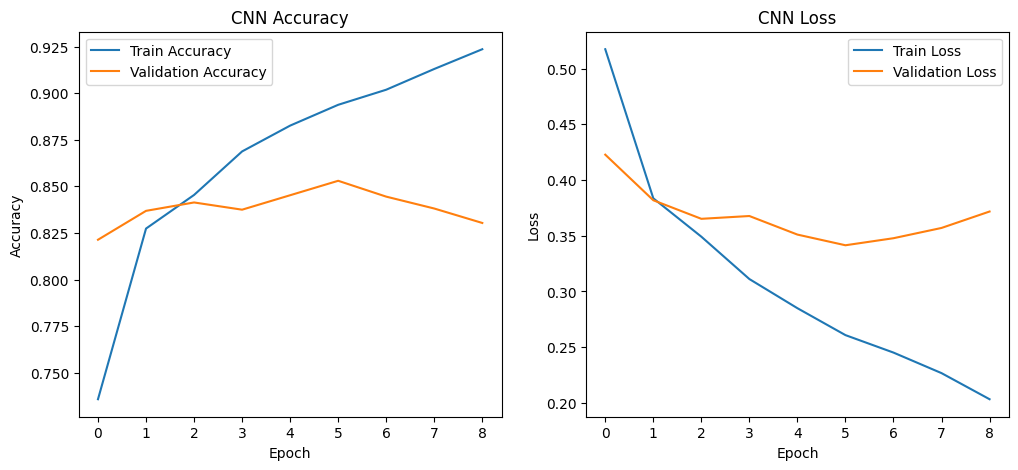

In [29]:
# Visualize performance for the CNN
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_cnn_dropout.history['acc'], label='Train Accuracy')
plt.plot(history_cnn_dropout.history['val_acc'], label='Validation Accuracy')
plt.title('CNN Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_cnn_dropout.history['loss'], label='Train Loss')
plt.plot(history_cnn_dropout.history['val_loss'], label='Validation Loss')
plt.title('CNN Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [30]:
#RNN
model_rnn_dropout = Sequential()
model_rnn_dropout.add(Embedding(vocab_size, embedding_dim, weights=[embedding_matrix],
                        input_length=maxlen, trainable=False))
# LSTM with dropout on inputs and recurrent connections
model_rnn_dropout.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model_rnn_dropout.add(Dense(1, activation='sigmoid'))

model_rnn_dropout.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
history_rnn_dropout = model_rnn_dropout.fit(X_train_pad, y_train, batch_size=128, epochs=20, verbose=1,
                           validation_split=0.2, callbacks=[early_stop])


Epoch 1/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 177s 694ms/step - acc: 0.6200 - loss: 0.6471 - val_acc: 0.7610 - val_loss: 0.5032
Epoch 2/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 190s 644ms/step - acc: 0.7378 - loss: 0.5324 - val_acc: 0.7841 - val_loss: 0.4555
Epoch 3/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 211s 679ms/step - acc: 0.7804 - loss: 0.4623 - val_acc: 0.8166 - val_loss: 0.4030
Epoch 4/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 161s 643ms/step - acc: 0.8070 - loss: 0.4260 - val_acc: 0.8145 - val_loss: 0.4044
Epoch 5/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 200s 637ms/step - acc: 0.8072 - loss: 0.4191 - val_acc: 0.8275 - val_loss: 0.3789
Epoch 6/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 201s 630ms/step - acc: 0.8209 - loss: 0.3966 - val_acc: 0.8385 - val_loss: 0.3606
Epoch 7/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 213s 673ms/step - acc: 0.8239 - loss: 0.3877 - val_acc: 0.8354 - val_loss: 0.3752
Epoch 8/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 160s 640ms/step - acc: 0.8347 - loss: 0.3745 - val_acc: 0.8438 - val_loss: 0.3506
Epoch 9/20
250/250 ━━━━━

In [31]:
print(model_rnn_dropout.summary())

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)              │ (128, 100, 100)             │       9,254,700 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (128, 128)                  │         117,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (128, 1)                    │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,606,833 (36.65 MB)

 Trainable params: 117,377 (458.50 KB)

 Non-trainable params: 9,254,700 (35.30 MB)

 Optimizer params: 234,756 (917.02 KB)

None


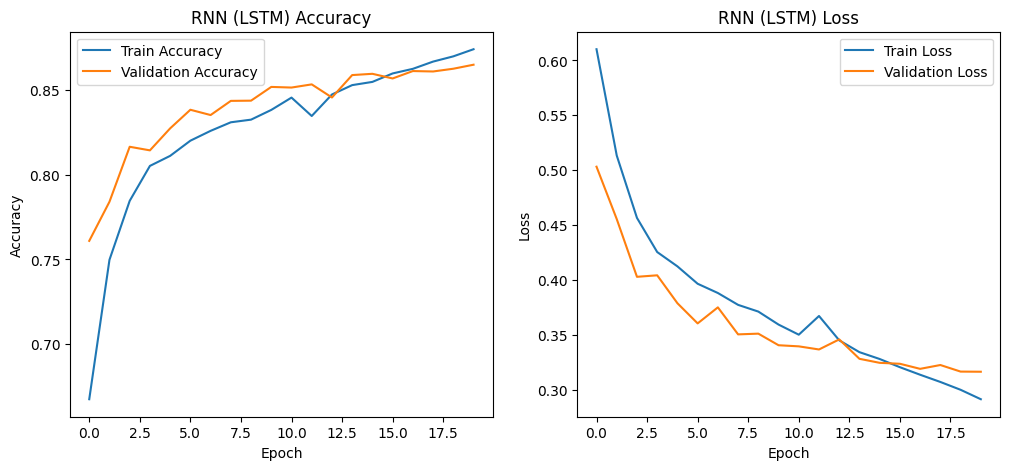

In [32]:
# Visualize performance for the RNN (LSTM)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_rnn_dropout.history['acc'], label='Train Accuracy')
plt.plot(history_rnn_dropout.history['val_acc'], label='Validation Accuracy')
plt.title('RNN (LSTM) Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_rnn_dropout.history['loss'], label='Train Loss')
plt.plot(history_rnn_dropout.history['val_loss'], label='Validation Loss')
plt.title('RNN (LSTM) Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 17s 52ms/step


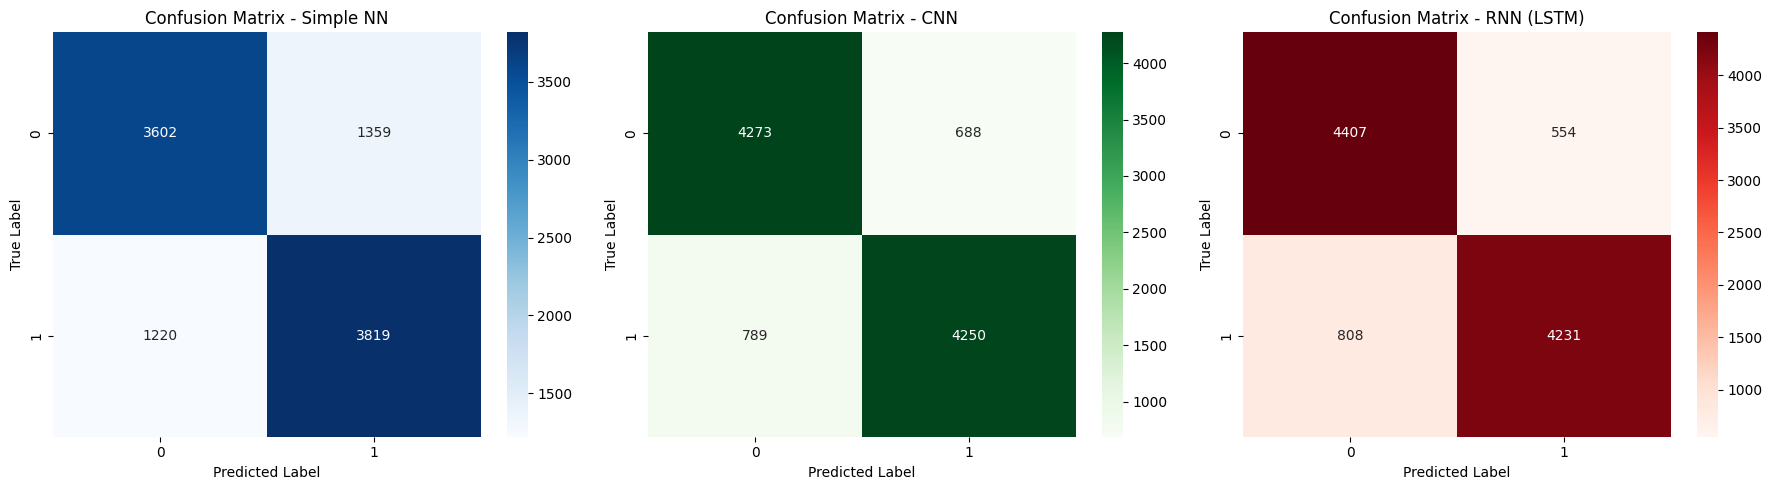

In [33]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Get predicted binary labels for the entire test set for each model
pred_nn = (model_nn_dropout.predict(X_test_pad) > 0.5).astype(int).flatten()
pred_cnn = (model_cnn_dropout.predict(X_test_pad) > 0.5).astype(int).flatten()
pred_rnn = (model_rnn_dropout.predict(X_test_pad) > 0.5).astype(int).flatten()

# Compute confusion matrices for each model
cm_nn = confusion_matrix(y_test, pred_nn)
cm_cnn = confusion_matrix(y_test, pred_cnn)
cm_rnn = confusion_matrix(y_test, pred_rnn)

# Plot the confusion matrices side by side
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.heatmap(cm_nn, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Confusion Matrix - Simple NN')
axes[0].set_xlabel('Predicted Label')
axes[0].set_ylabel('True Label')

sns.heatmap(cm_cnn, annot=True, fmt='d', cmap='Greens', ax=axes[1])
axes[1].set_title('Confusion Matrix - CNN')
axes[1].set_xlabel('Predicted Label')
axes[1].set_ylabel('True Label')

sns.heatmap(cm_rnn, annot=True, fmt='d', cmap='Reds', ax=axes[2])
axes[2].set_title('Confusion Matrix - RNN (LSTM)')
axes[2].set_xlabel('Predicted Label')
axes[2].set_ylabel('True Label')

plt.tight_layout()
plt.show()


# L2 Regularization and Early Stopping

In [34]:
#Simple NN with L2 Regularization and Early Stopping
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

model_nn_L2 = Sequential()
model_nn_L2.add(Embedding(vocab_size, embedding_dim, weights=[embedding_matrix],
                       input_length=maxlen, trainable=False))
model_nn_L2.add(Flatten())
model_nn_L2.add(Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(0.01)))

model_nn_L2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
history_nn_L2 = model_nn_L2.fit(X_train_pad, y_train, batch_size=128, epochs=20,
                          validation_split=0.2, callbacks=[early_stop])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - acc: 0.6250 - loss: 0.6669 - val_acc: 0.7315 - val_loss: 0.5624
Epoch 2/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - acc: 0.7678 - loss: 0.5283 - val_acc: 0.7279 - val_loss: 0.5749
Epoch 3/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - acc: 0.7849 - loss: 0.5127 - val_acc: 0.7410 - val_loss: 0.5612
Epoch 4/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - acc: 0.7922 - loss: 0.5024 - val_acc: 0.7486 - val_loss: 0.5627
Epoch 5/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - acc: 0.8004 - loss: 0.4983 - val_acc: 0.7364 - val_loss: 0.5758
Epoch 6/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - acc: 0.8072 - loss: 0.4927 - val_acc: 0.7381 - val_loss: 0.5779


In [35]:
print(model_nn_L2.summary())

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_6 (Embedding)              │ (128, 100, 100)             │       9,254,700 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (128, 10000)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (128, 1)                    │          10,001 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,284,705 (35.42 MB)

 Trainable params: 10,001 (39.07 KB)

 Non-trainable params: 9,254,700 (35.30 MB)

 Optimizer params: 20,004 (78.14 KB)

None


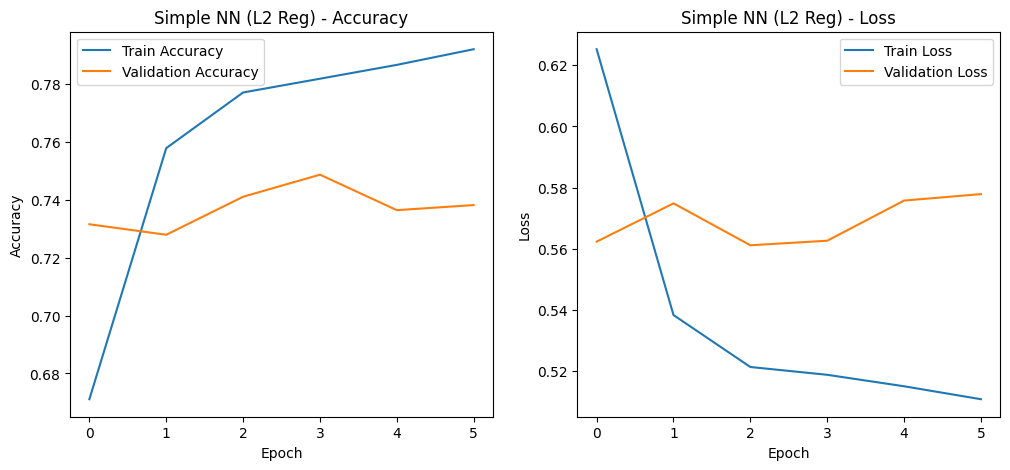

In [36]:
import matplotlib.pyplot as plt

# Visualize performance for the Simple NN with L2 Regularization
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_nn_L2.history['acc'], label='Train Accuracy')
plt.plot(history_nn_L2.history['val_acc'], label='Validation Accuracy')
plt.title('Simple NN (L2 Reg) - Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_nn_L2.history['loss'], label='Train Loss')
plt.plot(history_nn_L2.history['val_loss'], label='Validation Loss')
plt.title('Simple NN (L2 Reg) - Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [37]:
model_cnn_L2 = Sequential()
model_cnn_L2.add(Embedding(vocab_size, embedding_dim, weights=[embedding_matrix],
                        input_length=maxlen, trainable=False))
model_cnn_L2.add(Conv1D(128, 5, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model_cnn_L2.add(GlobalMaxPooling1D())
model_cnn_L2.add(Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(0.01)))

model_cnn_L2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
history_cnn_L2 = model_cnn_L2.fit(X_train_pad, y_train, batch_size=128, epochs=20,
                           validation_split=0.2, callbacks=[early_stop])


Epoch 1/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 28s 103ms/step - acc: 0.6756 - loss: 1.2492 - val_acc: 0.7906 - val_loss: 0.6069
Epoch 2/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 41s 102ms/step - acc: 0.8023 - loss: 0.5786 - val_acc: 0.8180 - val_loss: 0.5253
Epoch 3/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 27s 107ms/step - acc: 0.8116 - loss: 0.5312 - val_acc: 0.8238 - val_loss: 0.5120
Epoch 4/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 43s 114ms/step - acc: 0.8220 - loss: 0.5129 - val_acc: 0.8018 - val_loss: 0.5400
Epoch 5/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 37s 98ms/step - acc: 0.8186 - loss: 0.5161 - val_acc: 0.8129 - val_loss: 0.5199
Epoch 6/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 41s 98ms/step - acc: 0.8157 - loss: 0.5220 - val_acc: 0.8232 - val_loss: 0.5083
Epoch 7/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 41s 98ms/step - acc: 0.8233 - loss: 0.5088 - val_acc: 0.8269 - val_loss: 0.5053
Epoch 8/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 41s 98ms/step - acc: 0.8258 - loss: 0.5056 - val_acc: 0.8085 - val_loss: 0.5246
Epoch 9/20
250/250 ━━━━━━━━━━━━━━━━━

In [38]:
print(model_cnn_L2.summary())

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_7 (Embedding)              │ (128, 100, 100)             │       9,254,700 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (128, 96, 128)              │          64,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d_2               │ (128, 128)                  │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (128, 1)                    │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,447,473 (36.04 MB)

 Trainable params: 64,257 (251.00 KB)

 Non-trainable params: 9,254,700 (35.30 MB)

 Optimizer params: 128,516 (502.02 KB)

None


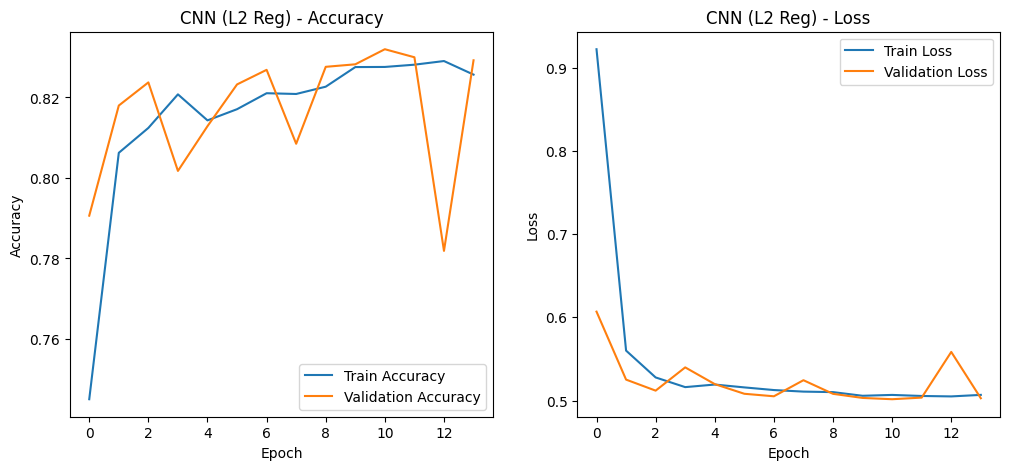

In [39]:
# Visualize performance for the CNN with L2 Regularization
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_cnn_L2.history['acc'], label='Train Accuracy')
plt.plot(history_cnn_L2.history['val_acc'], label='Validation Accuracy')
plt.title('CNN (L2 Reg) - Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_cnn_L2.history['loss'], label='Train Loss')
plt.plot(history_cnn_L2.history['val_loss'], label='Validation Loss')
plt.title('CNN (L2 Reg) - Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [40]:
#RNN (LSTM) with L2 Regularization and Early Stopping
model_rnn_L2 = Sequential()
model_rnn_L2.add(Embedding(vocab_size, embedding_dim, weights=[embedding_matrix],
                        input_length=maxlen, trainable=False))
model_rnn_L2.add(LSTM(128, kernel_regularizer=regularizers.l2(0.01)))
model_rnn_L2.add(Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(0.01)))

model_rnn_L2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
history_rnn_L2 = model_rnn_L2.fit(X_train_pad, y_train, batch_size=128, epochs=20,
                           validation_split=0.2, callbacks=[early_stop])


Epoch 1/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 85s 332ms/step - acc: 0.6489 - loss: 1.2536 - val_acc: 0.7670 - val_loss: 0.5920
Epoch 2/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 145s 344ms/step - acc: 0.7501 - loss: 0.6040 - val_acc: 0.7546 - val_loss: 0.5703
Epoch 3/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 142s 343ms/step - acc: 0.7663 - loss: 0.5586 - val_acc: 0.7893 - val_loss: 0.5249
Epoch 4/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 142s 343ms/step - acc: 0.7731 - loss: 0.5345 - val_acc: 0.7961 - val_loss: 0.4999
Epoch 5/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 86s 344ms/step - acc: 0.7859 - loss: 0.5086 - val_acc: 0.8046 - val_loss: 0.4780
Epoch 6/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 142s 343ms/step - acc: 0.7934 - loss: 0.4920 - val_acc: 0.8104 - val_loss: 0.4639
Epoch 7/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 139s 332ms/step - acc: 0.8031 - loss: 0.4786 - val_acc: 0.8156 - val_loss: 0.4526
Epoch 8/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 147s 351ms/step - acc: 0.8075 - loss: 0.4700 - val_acc: 0.8175 - val_loss: 0.4462
Epoch 9/20
250/250 ━━━━━━━

In [41]:
print(model_rnn_L2.summary())

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_8 (Embedding)              │ (128, 100, 100)             │       9,254,700 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (128, 128)                  │         117,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (128, 1)                    │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,606,833 (36.65 MB)

 Trainable params: 117,377 (458.50 KB)

 Non-trainable params: 9,254,700 (35.30 MB)

 Optimizer params: 234,756 (917.02 KB)

None


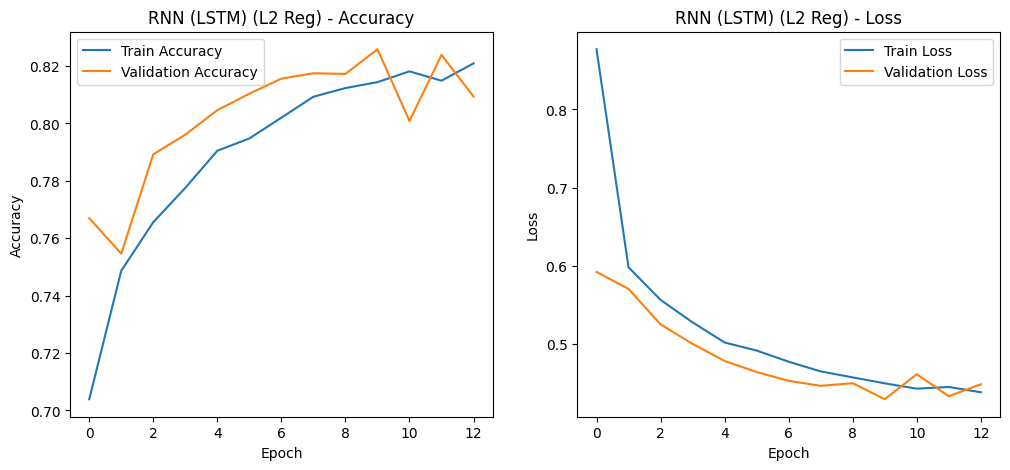

In [42]:
# Visualize performance for the RNN (LSTM) with L2 Regularization
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_rnn_L2.history['acc'], label='Train Accuracy')
plt.plot(history_rnn_L2.history['val_acc'], label='Validation Accuracy')
plt.title('RNN (LSTM) (L2 Reg) - Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_rnn_L2.history['loss'], label='Train Loss')
plt.plot(history_rnn_L2.history['val_loss'], label='Validation Loss')
plt.title('RNN (LSTM) (L2 Reg) - Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 19s 59ms/step


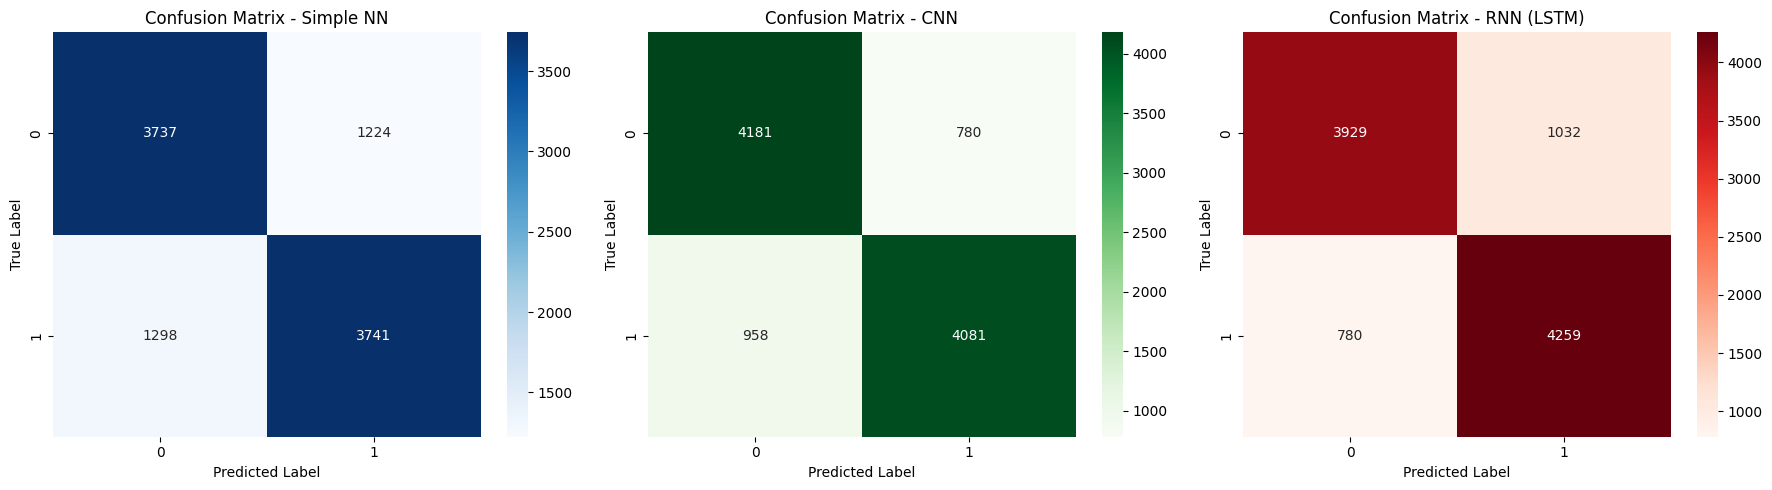

In [43]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Get predicted binary labels for the entire test set for each model
pred_nn = (model_nn_L2.predict(X_test_pad) > 0.5).astype(int).flatten()
pred_cnn = (model_cnn_L2.predict(X_test_pad) > 0.5).astype(int).flatten()
pred_rnn = (model_rnn_L2.predict(X_test_pad) > 0.5).astype(int).flatten()

# Compute confusion matrices for each model
cm_nn = confusion_matrix(y_test, pred_nn)
cm_cnn = confusion_matrix(y_test, pred_cnn)
cm_rnn = confusion_matrix(y_test, pred_rnn)

# Plot the confusion matrices side by side
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.heatmap(cm_nn, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Confusion Matrix - Simple NN')
axes[0].set_xlabel('Predicted Label')
axes[0].set_ylabel('True Label')

sns.heatmap(cm_cnn, annot=True, fmt='d', cmap='Greens', ax=axes[1])
axes[1].set_title('Confusion Matrix - CNN')
axes[1].set_xlabel('Predicted Label')
axes[1].set_ylabel('True Label')

sns.heatmap(cm_rnn, annot=True, fmt='d', cmap='Reds', ax=axes[2])
axes[2].set_title('Confusion Matrix - RNN (LSTM)')
axes[2].set_xlabel('Predicted Label')
axes[2].set_ylabel('True Label')

plt.tight_layout()
plt.show()


# Naive Bayes and SVM

In [44]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Transform the text data using TF-IDF, limiting to 5000 features
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# --- Naive Bayes Classifier ---
nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)
nb_pred = nb_model.predict(X_test_tfidf)
nb_acc = accuracy_score(y_test, nb_pred)
print("Naive Bayes Accuracy:", nb_acc)
print("Naive Bayes Confusion Matrix:\n", confusion_matrix(y_test, nb_pred))
print("Naive Bayes Classification Report:\n", classification_report(y_test, nb_pred))

# --- SVM Classifier ---
svm_model = LinearSVC()
svm_model.fit(X_train_tfidf, y_train)
svm_pred = svm_model.predict(X_test_tfidf)
svm_acc = accuracy_score(y_test, svm_pred)
print("SVM Accuracy:", svm_acc)
print("SVM Confusion Matrix:\n", confusion_matrix(y_test, svm_pred))
print("SVM Classification Report:\n", classification_report(y_test, svm_pred))


Naive Bayes Accuracy: 0.8524
Naive Bayes Confusion Matrix:
 [[4233  728]
 [ 748 4291]]
Naive Bayes Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.85      0.85      4961
           1       0.85      0.85      0.85      5039

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000

SVM Accuracy: 0.8888
SVM Confusion Matrix:
 [[4358  603]
 [ 509 4530]]
SVM Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.88      0.89      4961
           1       0.88      0.90      0.89      5039

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



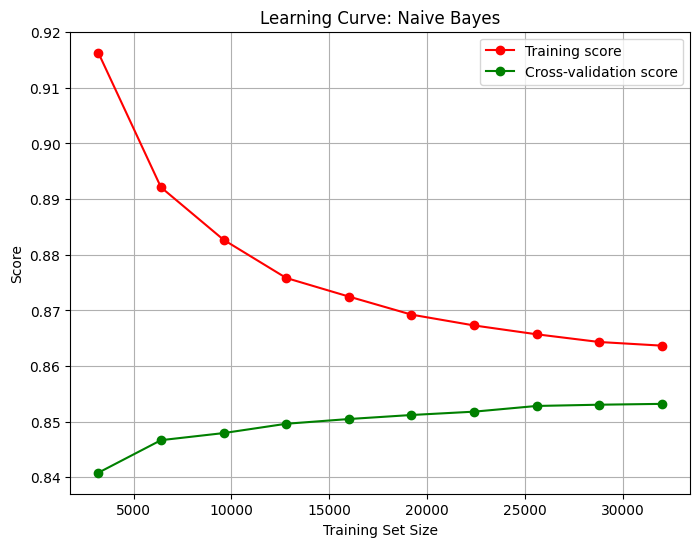

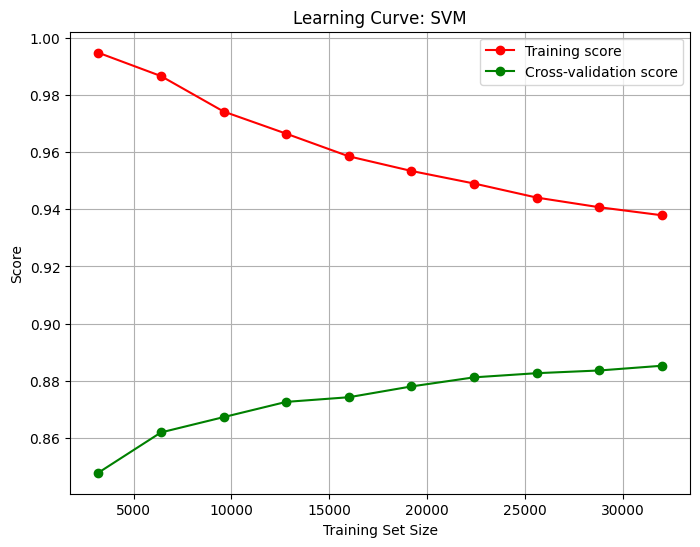

In [45]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, title, X, y, cv=5, n_jobs=-1):
    train_sizes, train_scores, val_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs,
        train_sizes=np.linspace(0.1, 1.0, 10)
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    val_scores_mean = np.mean(val_scores, axis=1)

    plt.figure(figsize=(8, 6))
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, val_scores_mean, 'o-', color="g", label="Cross-validation score")
    plt.title(title)
    plt.xlabel("Training Set Size")
    plt.ylabel("Score")
    plt.legend(loc="best")
    plt.grid()
    plt.show()

# Plot learning curves for Naive Bayes
plot_learning_curve(nb_model, "Learning Curve: Naive Bayes", X_train_tfidf, y_train, cv=5)

# Plot learning curves for SVM
plot_learning_curve(svm_model, "Learning Curve: SVM", X_train_tfidf, y_train, cv=5)


In [46]:
import numpy as np
from sklearn.model_selection import learning_curve

def get_learning_curve_data(estimator, X, y, cv=5, n_jobs=-1):
    train_sizes, train_scores, val_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs,
        train_sizes=np.linspace(0.1, 1.0, 10)
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    val_scores_mean = np.mean(val_scores, axis=1)
    return train_sizes, train_scores_mean, val_scores_mean

# Get learning curve data for Naive Bayes
train_sizes_nb, train_scores_nb, val_scores_nb = get_learning_curve_data(nb_model, X_train_tfidf, y_train)
print("Naive Bayes Learning Curve Data:")
print("Train Sizes:", train_sizes_nb)
print("Train Scores:", train_scores_nb)
print("Validation Scores:", val_scores_nb)

# Get learning curve data for SVM
train_sizes_svm, train_scores_svm, val_scores_svm = get_learning_curve_data(svm_model, X_train_tfidf, y_train)
print("\nSVM Learning Curve Data:")
print("Train Sizes:", train_sizes_svm)
print("Train Scores:", train_scores_svm)
print("Validation Scores:", val_scores_svm)


Naive Bayes Learning Curve Data:
Train Sizes: [ 3200  6400  9600 12800 16000 19200 22400 25600 28800 32000]
Train Scores: [0.9163125  0.892125   0.8826875  0.87582813 0.8724875  0.86923958
 0.86729464 0.86570313 0.86431944 0.8636625 ]
Validation Scores: [0.840825 0.846675 0.84795  0.849625 0.850475 0.8512   0.8518   0.852825
 0.85305  0.8532  ]

SVM Learning Curve Data:
Train Sizes: [ 3200  6400  9600 12800 16000 19200 22400 25600 28800 32000]
Train Scores: [0.9946875  0.98653125 0.97414583 0.96640625 0.9584875  0.953375
 0.94899107 0.94407813 0.94070139 0.93789375]
Validation Scores: [0.847925 0.862025 0.867375 0.8727   0.874325 0.8781   0.881275 0.882725
 0.883675 0.885325]


In [47]:
#Adjusted SVM Model with Increased Regularization
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Create a new SVM model with a lower C value for stronger regularization
svm_model_adjusted = LinearSVC(C=0.1)
svm_model_adjusted.fit(X_train_tfidf, y_train)

# Predict on the test set
svm_pred_adjusted = svm_model_adjusted.predict(X_test_tfidf)
svm_acc_adjusted = accuracy_score(y_test, svm_pred_adjusted)
print("Adjusted SVM Accuracy:", svm_acc_adjusted)
print("Adjusted SVM Confusion Matrix:\n", confusion_matrix(y_test, svm_pred_adjusted))
print("Adjusted SVM Classification Report:\n", classification_report(y_test, svm_pred_adjusted))


Adjusted SVM Accuracy: 0.8966
Adjusted SVM Confusion Matrix:
 [[4377  584]
 [ 450 4589]]
Adjusted SVM Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.88      0.89      4961
           1       0.89      0.91      0.90      5039

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



In [48]:
import numpy as np
from sklearn.model_selection import learning_curve

def get_learning_curve_data(estimator, X, y, cv=5, n_jobs=-1):
    train_sizes, train_scores, val_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs,
        train_sizes=np.linspace(0.1, 1.0, 10)
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    val_scores_mean = np.mean(val_scores, axis=1)
    return train_sizes, train_scores_mean, val_scores_mean

# Get learning curve data for the adjusted SVM model
train_sizes_svm_adj, train_scores_svm_adj, val_scores_svm_adj = get_learning_curve_data(svm_model_adjusted, X_train_tfidf, y_train)

print("Adjusted SVM Learning Curve Data:")
print("Train Sizes:", train_sizes_svm_adj)
print("Train Scores:", train_scores_svm_adj)
print("Validation Scores:", val_scores_svm_adj)


Adjusted SVM Learning Curve Data:
Train Sizes: [ 3200  6400  9600 12800 16000 19200 22400 25600 28800 32000]
Train Scores: [0.930875   0.92259375 0.91875    0.91795313 0.9170625  0.9170625
 0.9169375  0.91541406 0.91483333 0.914325  ]
Validation Scores: [0.847375 0.86625  0.872375 0.877475 0.880325 0.88315  0.8857   0.88715
 0.8878   0.8884  ]


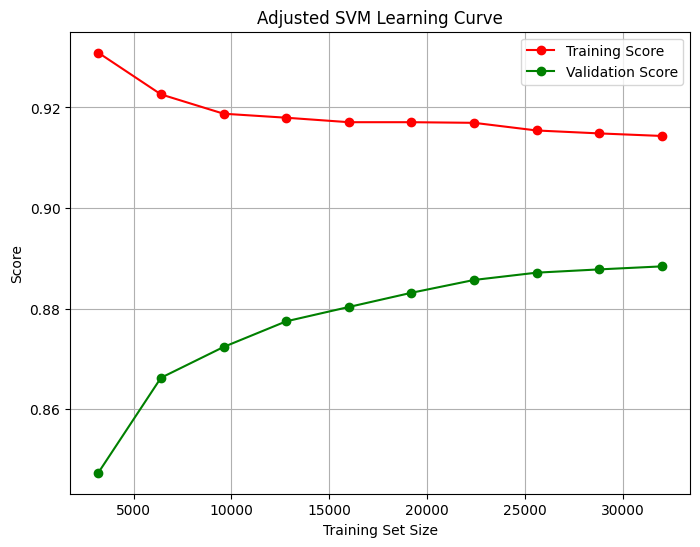

In [49]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.plot(train_sizes_svm_adj, train_scores_svm_adj, 'o-', color="r", label="Training Score")
plt.plot(train_sizes_svm_adj, val_scores_svm_adj, 'o-', color="g", label="Validation Score")
plt.title("Adjusted SVM Learning Curve")
plt.xlabel("Training Set Size")
plt.ylabel("Score")
plt.legend(loc="best")
plt.grid(True)
plt.show()
